In [14]:
# H0: mean(control's SkinThickness) = mean(treatment's SkinThickness)
# H1: mean(control's SkinThickness) <= mean(treatment's SkinThickness)

BINS = 10

ALPHA = 0.05
CONFIDENCE = 0.95

X = "NonWhite"
Y = "Education"

X_THRESHOLD = 0.5

URL = "https://course-resources.minerva.edu/uploaded_files/mu/00294347-0809/sf-sea-level-rise-sample.csv"


## Setup

In [3]:
import pandas
import numpy

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy import stats
from typing import Iterable


In [4]:
df = pandas.read_csv(URL)
df = df[(df[X] != 0) & (df[Y] != 0)]


white = df[df[X] < X_THRESHOLD]
black = df[df[X] >= X_THRESHOLD]

## #descriptivestats

In [5]:
print(df.describe()[[X, Y]])
print(white.describe()[[X, Y]])
print(black.describe()[[X, Y]])


        NonWhite  Education
count  60.000000  60.000000
mean    0.589638   0.857605
std     0.204536   0.109820
min     0.128998   0.539999
25%     0.481250   0.804000
50%     0.569000   0.888000
75%     0.742500   0.937197
max     0.981262   1.000996
        NonWhite  Education
count  20.000000  20.000000
mean    0.367761   0.945674
std     0.115575   0.041436
min     0.128998   0.853000
25%     0.290750   0.918500
50%     0.398580   0.960585
75%     0.463750   0.974000
max     0.494667   1.000996
        NonWhite  Education
count  40.000000  40.000000
mean    0.700577   0.813570
std     0.137522   0.106969
min     0.511000   0.539999
25%     0.571000   0.771499
50%     0.682500   0.824004
75%     0.799250   0.896998
max     0.981262   0.942001


In [29]:
print(f"{X} median, {Y} median for white")
print(white[X].median(), white[Y].median())

NonWhite median, Education median for white
0.39857999999999993 0.960584645


In [30]:
print(f"{X} median, {Y} median for black")
print(black[X].median(), black[Y].median())

NonWhite median, Education median for black
0.6825005 0.824004425


## #distributions

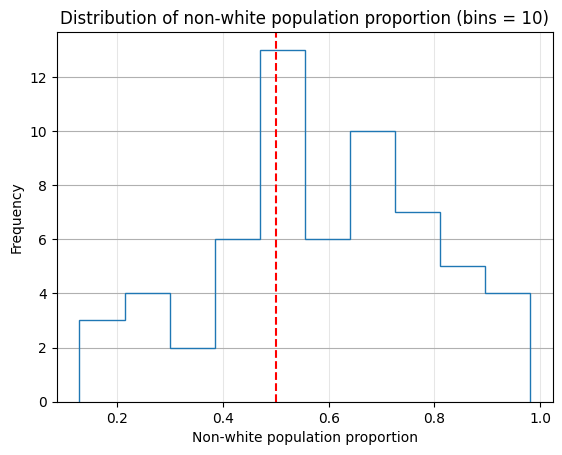

In [23]:
bins = 10

figure, ax = plt.subplots()
df.hist(column=X, bins=bins, histtype="step", ax=ax)
ax.axvline(X_THRESHOLD, color="r", ls="--")
ax.set_title(f"Distribution of non-white population proportion (bins = {bins})")
ax.set_xlabel("Non-white population proportion")
ax.set_ylabel("Frequency")
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.grid(which="major", axis="x", linewidth=0.75, linestyle="-", color="0.9")
ax.grid(which="minor", axis="x", linewidth=0.25, linestyle="-", color="0.8")
plt.savefig("sonja_figure1.png", dpi=600)
plt.show()


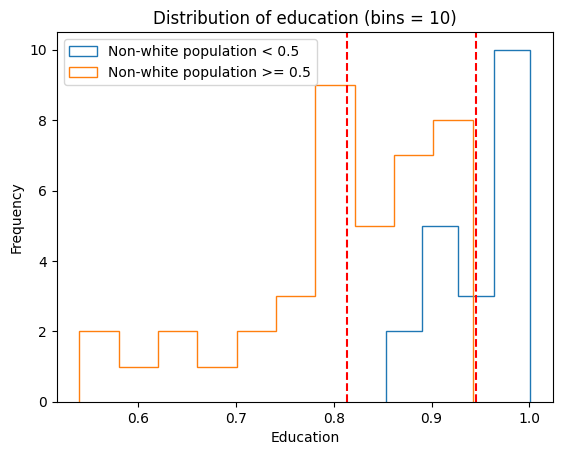

In [24]:
control_range = white[Y].max() - white[Y].min()
treatment_range = black[Y].max() - black[Y].min()
max_range = max(control_range, treatment_range)
control_bins = round(control_range / max_range * BINS)
treatment_bins = round(treatment_range / max_range * BINS)

figure, ax = plt.subplots()

ax.hist(
    white[Y],
    # label=f"{Y} < {X_THRESHOLD}",
    label=f"Non-white population < {X_THRESHOLD}",
    bins=control_bins,
    histtype="step",
)
ax.axvline(numpy.mean(white[Y]), color="r", ls="--")

ax.hist(
    black[Y],
    # label=f"{Y} >= {X_THRESHOLD}",
    label=f"Non-white population >= {X_THRESHOLD}",
    bins=treatment_bins,
    histtype="step",
)
ax.axvline(numpy.mean(black[Y]), color="r", ls="--")

ax.set_title(f"Distribution of education (bins = {BINS})")
ax.set_xlabel("Education")
ax.set_ylabel("Frequency")
# ax.grid(which="major", axis="x", linewidth=0.75, linestyle="-", color="0.9")
# ax.grid(which="minor", axis="x", linewidth=0.25, linestyle="-", color="0.8")
plt.legend()
plt.savefig("sonja_figure2.png", dpi=600)
plt.show()


## #significance

In [17]:
def difference_of_means_test(
    control: Iterable[float], treatment: Iterable[float], tails: int = 1
):
    n_1, n_2 = len(control), len(treatment)
    x_1, x_2 = numpy.mean(control), numpy.mean(treatment)

    # sample SD formula (aka Bessel’s correction): use n-1 in denominator
    s_1, s_2 = numpy.std(control, ddof=1), numpy.std(treatment, ddof=1)

    # conservative estimate from OpenIntro
    DOF = min(n_1, n_2) - 1

    SE = numpy.sqrt(s_1**2 / n_1 + s_2**2 / n_2)
    t_score = numpy.abs((x_2 - x_1)) / SE
    p_value = tails * stats.t.cdf(-t_score, DOF)

    # OpenIntro section 5.3.6
    pooled_SD = numpy.sqrt(
        (s_1**2 * (n_1 - 1) + s_2**2 * (n_2 - 1)) / (n_1 + n_2 - 2)
    )
    cohen_d = (x_2 - x_1) / pooled_SD

    return p_value, cohen_d


In [26]:
p_value, cohen_d = difference_of_means_test(
    white[Y], black[Y], tails=2
)
print(f"p-value: {p_value}, Cohen's d: {cohen_d}")


p-value: 1.5483509410856891e-06, Cohen's d: -1.4538461053727096


## Central Limit Theorem

In [27]:
# this function implements the full sampling process
def sample_procedure(pop_dist, n, repeats):
    sample_means = []

    for i in range(repeats):
        sample = numpy.random.choice(pop_dist, n)
        # by default, numpy.random.choice uses replace=True
        this_mean = numpy.mean(sample)
        sample_means.append(this_mean)
    return sample_means


# this function creates an upper and lower bound for a confidence interval
def confidence_interval(point_estimate, SE, conf_level):
    z = stats.norm.ppf(
        1 - (1 - conf_level) / 2
    )  # gives 1.96 for a 95% confidence level
    lowbound = point_estimate - z * SE
    highbound = point_estimate + z * SE
    return lowbound, highbound


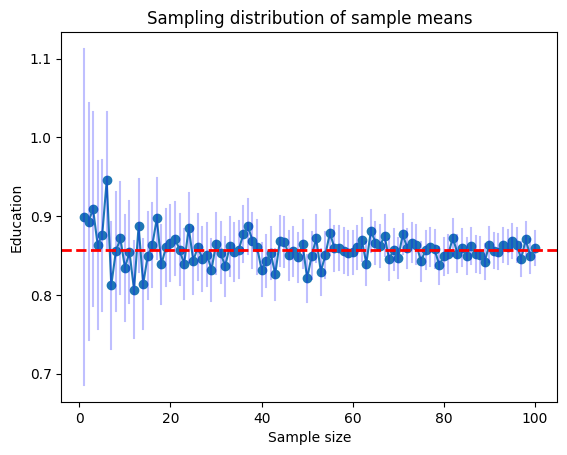

In [28]:
max_sample_size = 100
population = df[Y]
SD = numpy.std(population)

sample_means = []
cis = []
for sample_size in range(1, max_sample_size + 1):
    SE = SD / numpy.sqrt(sample_size)
    sample = numpy.random.choice(population, sample_size)
    sample_mean = numpy.mean(sample)
    sample_means.append(sample_mean)
    cis.append(confidence_interval(sample_mean, SE, CONFIDENCE))

plt.scatter(range(1, max_sample_size + 1), sample_means)
plt.plot(range(1, max_sample_size + 1), sample_means)

for i in range(len(cis)):
    plt.plot([i + 1, i + 1], cis[i], color="b", alpha=0.25)

plt.axhline(numpy.mean(population), color="r", linestyle="--", linewidth=2)
plt.title("Sampling distribution of sample means")
plt.xlabel("Sample size")
plt.ylabel("Education")
plt.savefig("sonja_figure3.png", dpi=600)
plt.show()
